# Quantum Espresso Energy Volume Curve Workflow with pyiron_base

## Define workflow with pyiron_base

In [1]:
import numpy as np
from pyiron_base import Project, job
from python_workflow_definition.pyiron_base import write_workflow_json

In [2]:
from quantum_espresso_workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [3]:
workflow_json_filename = "pyiron_base_qe.json"

In [4]:
calculate_qe = job(_calculate_qe, output_key_lst=["energy", "volume", "structure"])
generate_structures = job(_generate_structures)
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [5]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [6]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [7]:
structure = get_bulk_structure(
    element="Al",
    a=4.05,
    cubic=True,
    pyiron_project=pr,
)

In [8]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
    pyiron_project=pr,
)

In [9]:
number_of_strains = 5
structure_lst = generate_structures(  # the generate_structures() function is not available in the workflow graph
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
    pyiron_project=pr,
    list_length=number_of_strains,
)

In [10]:
job_strain_lst = []
for i, structure_strain in enumerate(structure_lst):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": structure_strain,
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
        pyiron_project=pr,
    )
    job_strain_lst.append(calc_strain)

In [11]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
    pyiron_project=pr,
)

In [12]:
write_workflow_json(delayed_object=plot, file_name=workflow_json_filename)

In [13]:
!cat {workflow_json_filename}

{"nodes": {"0": "quantum_espresso_workflow.plot_energy_volume_curve", "1": "python_workflow_definition.shared.get_list", "2": "quantum_espresso_workflow.calculate_qe", "3": "python_workflow_definition.shared.get_dict", "4": "quantum_espresso_workflow.generate_structures", "5": "quantum_espresso_workflow.calculate_qe", "6": "python_workflow_definition.shared.get_dict", "7": "quantum_espresso_workflow.get_bulk_structure", "8": "quantum_espresso_workflow.calculate_qe", "9": "python_workflow_definition.shared.get_dict", "10": "quantum_espresso_workflow.calculate_qe", "11": "python_workflow_definition.shared.get_dict", "12": "quantum_espresso_workflow.calculate_qe", "13": "python_workflow_definition.shared.get_dict", "14": "quantum_espresso_workflow.calculate_qe", "15": "python_workflow_definition.shared.get_dict", "16": "python_workflow_definition.shared.get_list", "17": "strain_0", "18": "mini", "19": "Al", "20": 4.05, "21": true, "22": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, "23": [3, 3,

## Load Workflow with aiida

In [14]:
from aiida import load_profile

load_profile()

Profile<uuid='bcf9e395e4bf4b64a0a705d8659c0a9c' name='default'>

In [15]:
from python_workflow_definition.aiida import load_workflow_json

In [16]:
wg = load_workflow_json(file_name=workflow_json_filename)

04/01/2025 10:56:19 AM <3368622> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51282|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure8
04/01/2025 10:56:20 AM <3368622> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51282|WorkGraphEngine|update_task_state]: Task: get_bulk_structure8, type: PyFunction, finished.
04/01/2025 10:56:21 AM <3368622> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51282|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict7
04/01/2025 10:56:22 AM <3368622> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51282|WorkGraphEngine|update_task_state]: Task: get_dict7, type: PyFunction, finished.
04/01/2025 10:56:22 AM <3368622> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [51282|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe6
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLA

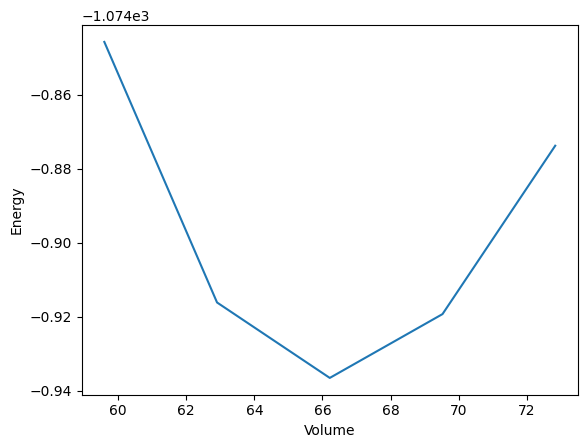

In [17]:
wg.run()

## Load Workflow with jobflow

In [18]:
from python_workflow_definition.jobflow import load_workflow_json

In [19]:
from jobflow.managers.local import run_locally

In [20]:
flow = load_workflow_json(file_name=workflow_json_filename)

2025-04-01 10:57:31,434 INFO Started executing jobs locally
2025-04-01 10:57:31,534 INFO Starting job - get_bulk_structure (c4dbc1c3-08e2-4517-88b1-55b2b14fae2b)
2025-04-01 10:57:31,539 INFO Finished job - get_bulk_structure (c4dbc1c3-08e2-4517-88b1-55b2b14fae2b)
2025-04-01 10:57:31,541 INFO Starting job - get_dict (a6e8e886-8bbb-488a-8125-46cdfb4dedb4)
2025-04-01 10:57:31,545 INFO Finished job - get_dict (a6e8e886-8bbb-488a-8125-46cdfb4dedb4)
2025-04-01 10:57:31,545 INFO Starting job - calculate_qe (d0d3f8f7-9c1e-4e26-a49a-9637c759bd64)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:57:49,723 INFO Finished job - calculate_qe (d0d3f8f7-9c1e-4e26-a49a-9637c759bd64)
2025-04-01 10:57:49,724 INFO Starting job - generate_structures (3c77f030-1b28-45dc-934e-d85147676f34)
2025-04-01 10:57:49,737 INFO Finished job - generate_structures (3c77f030-1b28-45dc-934e-d85147676f34)
2025-04-01 10:57:49,738 INFO Starting job - get_dict (5baee8fe-01f3-4a49-b589-8eb2547bd61f)
2025-04-01 10:57:49,741 INFO Finished job - get_dict (5baee8fe-01f3-4a49-b589-8eb2547bd61f)
2025-04-01 10:57:49,742 INFO Starting job - get_dict (1c0e5563-998a-4adb-8036-3c3f65dc3e4a)
2025-04-01 10:57:49,744 INFO Finished job - get_dict (1c0e5563-998a-4adb-8036-3c3f65dc3e4a)
2025-04-01 10:57:49,745 INFO Starting job - get_dict (e5660385-b8ff-4a58-9349-520757d80a7d)
2025-04-01 10:57:49,748 INFO Finished job - get_dict (e5660385-b8ff-4a58-9349-520757d80a7d)
2025-04-01 10:57:49,748 INFO Starting job - get_dict (07bf6634-c9b2-4d98-b6db-96147a5e89f7)
2025-04-01 10:57:49,751 INFO Finished job - get_dict (

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:57:53,583 INFO Finished job - calculate_qe (39512b85-df17-48f3-a064-9f322b68a2ac)
2025-04-01 10:57:53,584 INFO Starting job - calculate_qe (227561a6-47b5-4ba4-bd3f-2e59c6089e0b)
2025-04-01 10:57:57,547 INFO Finished job - calculate_qe (227561a6-47b5-4ba4-bd3f-2e59c6089e0b)
2025-04-01 10:57:57,548 INFO Starting job - calculate_qe (ff2920f8-72e0-4b58-8828-d1b30f60fcb1)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:58:02,366 INFO Finished job - calculate_qe (ff2920f8-72e0-4b58-8828-d1b30f60fcb1)
2025-04-01 10:58:02,367 INFO Starting job - calculate_qe (bbcd53dc-eb58-4567-b727-476d1b9393d3)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:58:06,956 INFO Finished job - calculate_qe (bbcd53dc-eb58-4567-b727-476d1b9393d3)
2025-04-01 10:58:06,957 INFO Starting job - calculate_qe (8c3828c4-4687-41c0-906f-fc82bba1c17c)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-01 10:58:10,586 INFO Finished job - calculate_qe (8c3828c4-4687-41c0-906f-fc82bba1c17c)
2025-04-01 10:58:10,587 INFO Starting job - get_list (e068c427-b5e7-4507-a707-2de7ed1c1583)
2025-04-01 10:58:10,594 INFO Finished job - get_list (e068c427-b5e7-4507-a707-2de7ed1c1583)
2025-04-01 10:58:10,595 INFO Starting job - get_list (fc038980-8d36-46d9-a221-b11dadbec44a)
2025-04-01 10:58:10,600 INFO Finished job - get_list (fc038980-8d36-46d9-a221-b11dadbec44a)
2025-04-01 10:58:10,601 INFO Starting job - plot_energy_volume_curve (38549ff7-2e75-43c2-aaf2-15f9f85fd3a6)
2025-04-01 10:58:10,672 INFO Finished job - plot_energy_volume_curve (38549ff7-2e75-43c2-aaf2-15f9f85fd3a6)
2025-04-01 10:58:10,673 INFO Finished executing jobs locally


{'c4dbc1c3-08e2-4517-88b1-55b2b14fae2b': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structure_features": []}', detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/wang_x3/repos/superstar54/python-workflow-definition'))},
 'a

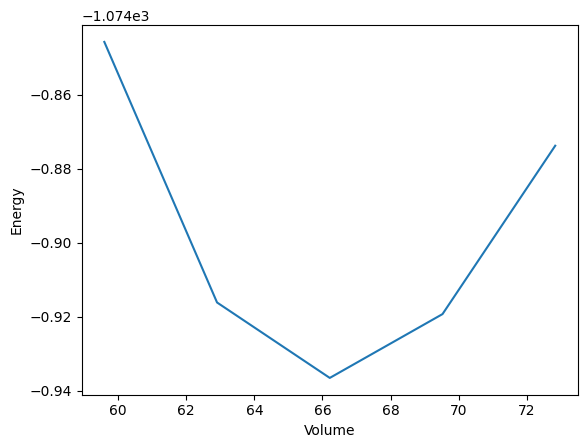

In [21]:
result = run_locally(flow)
result